In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-play-store-apps/googleplaystore.csv
/kaggle/input/google-play-store-apps/license.txt
/kaggle/input/google-play-store-apps/googleplaystore_user_reviews.csv


# Data info

* App - Application name
* Category - Category the app belongs to
* Rating - Overall user rating of the app (as when scraped)
* Reviews - Number of user reviews for the app (as when scraped)
* Size - Size of the app (as when scraped)
* Installs - Number of user downloads/installs for the app (as when scraped)
* Type - Paid or Free
* Price - Price of the app (as when scraped)
* Content Rating - Age group the app is targeted at - Children / Mature 21+ / Adult
* Genres - An app can belong to multiple genres (apart from its main category). For eg, a musical family game will belong to
* Last Updated - Date when the app was last updated on Play Store (as when scraped)
* Current Ver - Current version of the app available on Play Store (as when scraped)
* Android Ver - Min required Android version (as when scraped)

# Импорт


In [39]:
import numpy as np
import pandas as pd
import re

from tqdm import tqdm
from IPython.display import display, HTML

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, learning_curve, LearningCurveDisplay
import optuna
from optuna.samplers import TPESampler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, QuantileTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, top_k_accuracy_score, confusion_matrix

from sklearn.decomposition import PCA

from sklearn.cluster import OPTICS, KMeans, DBSCAN
from sklearn.metrics.cluster import homogeneity_score, fowlkes_mallows_score
from sklearn.metrics import adjusted_mutual_info_score

# Предварительная обработка

In [40]:
data = pd.read_csv('/kaggle/input/google-play-store-apps/googleplaystore.csv')
print(f'Row nums - {data.shape[0]}')
data.head(10)

Row nums - 10841


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


In [41]:
print(f"Nan obj in data: {bool(sum(data.isna().sum().tolist()))}")
data.isna().sum()

Nan obj in data: True


App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [42]:
data_not_nun = data.dropna()
print(f"Nan obj in data: {bool(sum(data_not_nun.isna().sum().tolist()))}")
print(f'Row nums - {data_not_nun.shape[0]}')

Nan obj in data: False
Row nums - 9360


In [43]:
data_not_nun.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   object 
 4   Size            9360 non-null   object 
 5   Installs        9360 non-null   object 
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   object 
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
 10  Last Updated    9360 non-null   object 
 11  Current Ver     9360 non-null   object 
 12  Android Ver     9360 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


In [44]:
data_not_nun = data_not_nun.drop_duplicates()
data_not_nun.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8886 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8886 non-null   object 
 1   Category        8886 non-null   object 
 2   Rating          8886 non-null   float64
 3   Reviews         8886 non-null   object 
 4   Size            8886 non-null   object 
 5   Installs        8886 non-null   object 
 6   Type            8886 non-null   object 
 7   Price           8886 non-null   object 
 8   Content Rating  8886 non-null   object 
 9   Genres          8886 non-null   object 
 10  Last Updated    8886 non-null   object 
 11  Current Ver     8886 non-null   object 
 12  Android Ver     8886 non-null   object 
dtypes: float64(1), object(12)
memory usage: 971.9+ KB


In [45]:
for column_name in data_not_nun.columns:
    print(f'Column name - {column_name}')
    print(f'Unique count - {len(data_not_nun[column_name].unique())}')
    print(data_not_nun[column_name].unique(), '\n')

Column name - App
Unique count - 8190
['Photo Editor & Candy Camera & Grid & ScrapBook' 'Coloring book moana'
 'U Launcher Lite – FREE Live Cool Themes, Hide Apps' ...
 'Fr. Mike Schmitz Audio Teachings' 'The SCP Foundation DB fr nn5n'
 'iHoroscope - 2018 Daily Horoscope & Astrology'] 

Column name - Category
Unique count - 33
['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION'] 

Column name - Rating
Unique count - 39
[4.1 3.9 4.7 4.5 4.3 4.4 3.8 4.2 4.6 4.  4.8 4.9 3.6 3.7 3.2 3.3 3.4 3.5
 3.1 5.  2.6 3.  1.9 2.5 2.8 2.7 1.  2.9 2.3 2.2 1.7 2.  1.8 2.4 1.6 2.1
 1.4 1.5 1.2] 

Co

In [46]:
data_typed = data_not_nun.copy()

# Преобразование в float и удаление знака $
data_typed['Price'] = data_not_nun['Price'].copy().replace('[$,]', '', regex=True).astype(float)

# Преобразование в int и удаление знаков + and ,
data_typed['Installs'] = data_not_nun['Installs'].copy().replace('\D', '', regex=True).astype(int)

# Преобразование в int оставляя только год
data_typed['Last Updated'] = data_not_nun['Last Updated'].copy().str[-4:].astype(int)

# Преобразование в int
data_typed['Reviews'] = data_not_nun['Reviews'].copy().astype(int)

# Преобразование в mB типа float
# может быть, это хорошая идея, что мы можем заменить "Зависит от устройства" на среднее значение в тех же группах "Жанров" или "Категорий"
mapping = {'M': '',
           'k': ' / 1024',
           'Varies with device': '0.0'}

data_typed['Size'] = data_not_nun['Size'].copy().replace(mapping, regex=True).map(pd.eval).astype(float)
data_typed['Size'] = data_typed['Size'].replace(0.0, np.nan, regex=False).astype(float)
data_typed['Size'] = data_typed.groupby('Category')['Size'].transform(lambda x: x.fillna(x.median()))
data_typed

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,2018,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,2018,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10834,FR Calculator,FAMILY,4.0,7,2.6,500,Free,0.0,Everyone,Education,2017,1.0.0,4.1 and up
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53.0,5000,Free,0.0,Everyone,Education,2017,1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,100,Free,0.0,Everyone,Education,2018,1.0,4.1 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,7.2,1000,Free,0.0,Mature 17+,Books & Reference,2015,Varies with device,Varies with device


# Анализ


In [47]:
pd.concat([data_typed.groupby('Category')['Size'].mean(), data_typed.groupby('Category')['Size'].median()], axis=1)

,Size,Size
Category,,
ART_AND_DESIGN,12.760656,9.30
AUTO_AND_VEHICLES,21.073973,16.50
BEAUTY,15.095238,12.00
BOOKS_AND_REFERENCE,12.992655,7.20
BUSINESS,13.588889,9.80
COMICS,12.994828,10.00
COMMUNICATION,11.693485,8.40
DATING,17.077358,13.00
EDUCATION,19.490698,17.00


In [48]:
data_typed.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,8886.0,4.187959e+00,5.224279e-01,1.000000,4.0,4.3,4.50,5.000000e+00
Reviews,8886.0,4.730928e+05,2.906007e+06,1.000000,164.0,4723.0,71313.25,7.815831e+07
Size,8886.0,2.174010e+01,2.176628e+01,0.008301,6.6,14.0,29.00,1.000000e+02
Installs,8886.0,1.650061e+07,8.640413e+07,1.000000,10000.0,500000.0,5000000.00,1.000000e+09
Price,8886.0,9.635258e-01,1.619479e+01,0.000000,0.0,0.0,0.00,4.000000e+02
Last Updated,8886.0,2.017402e+03,1.115993e+00,2010.000000,2017.0,2018.0,2018.00,2.018000e+03


In [49]:
data_typed.describe(include='object').T

,count,unique,top,freq
App,8886,8190,ROBLOX,9
Category,8886,33,FAMILY,1717
Type,8886,2,Free,8275
Content Rating,8886,6,Everyone,7089
Genres,8886,115,Tools,732
Current Ver,8886,2638,Varies with device,1258
Android Ver,8886,31,4.1 and up,1987


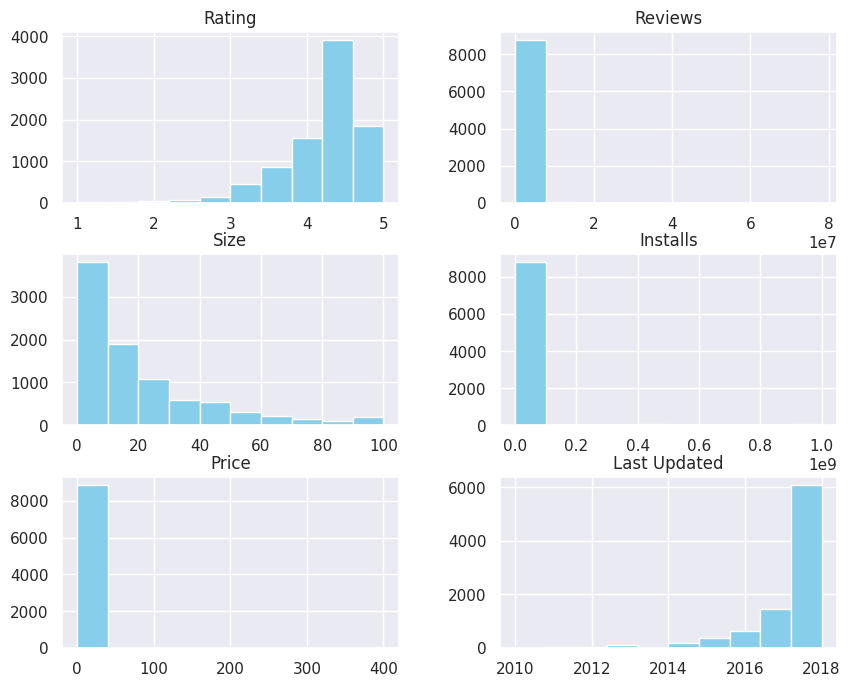

In [50]:
sns.set(rc={'figure.figsize': (10, 8)})

data_typed.hist(color="skyblue");

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Figure size 1000x800 with 0 Axes>

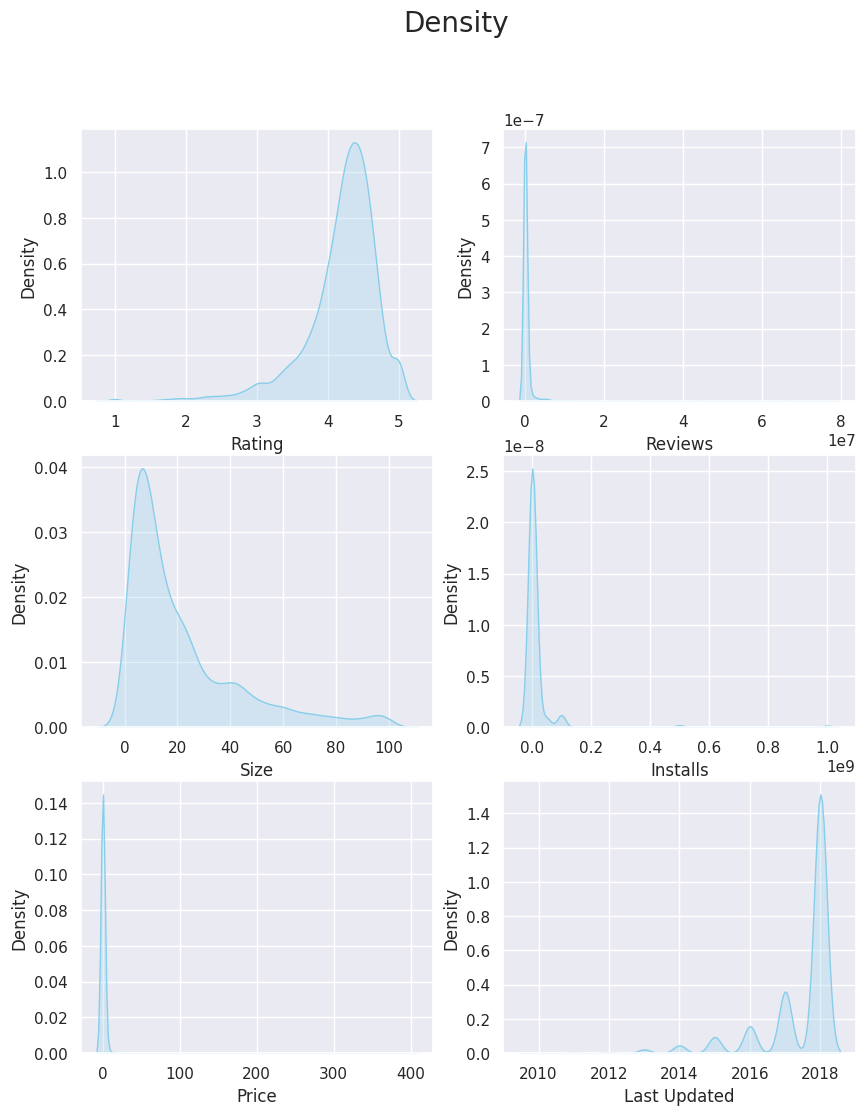

In [51]:
plt.clf()
fig, axes = plt.subplots(3, 2, figsize=(10,12))

fig.suptitle('Density', size=20)
for i, name in enumerate(data_typed.select_dtypes(include=['int64', 'float64']).columns):
    sns.kdeplot(data_typed[name],
                fill=True,
                color="skyblue",
                legend=False,
                ax=axes[int(i / 2), i % 2])
plt.show();

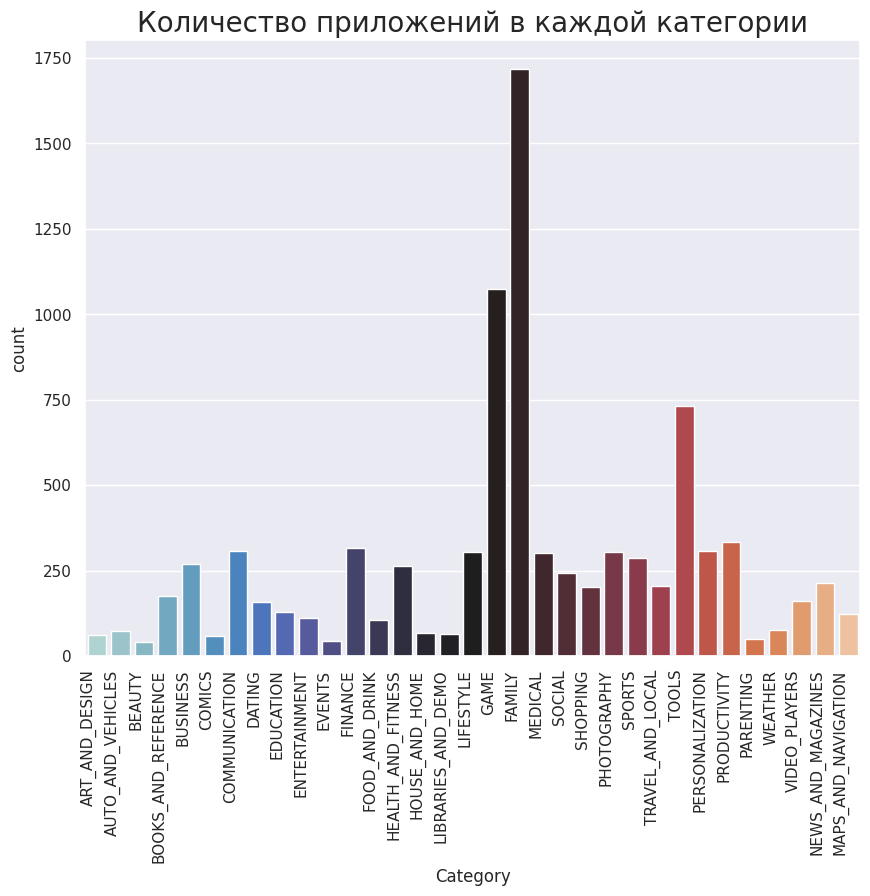

In [52]:
plt.clf()
sns.set(rc={'figure.figsize': (10, 7)})

countplot = sns.countplot(x="Category",
                          data=data_typed,
                          palette="icefire");

countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90, ha="right")

plt.title('Количество приложений в каждой категории',size = 20);

In [53]:
data_typed.groupby('Content Rating')[['App']].count().rename(columns={'App': 'Count'})

,Count
Content Rating,
Adults only 18+,3
Everyone,7089
Everyone 10+,360
Mature 17+,411
Teen,1022
Unrated,1


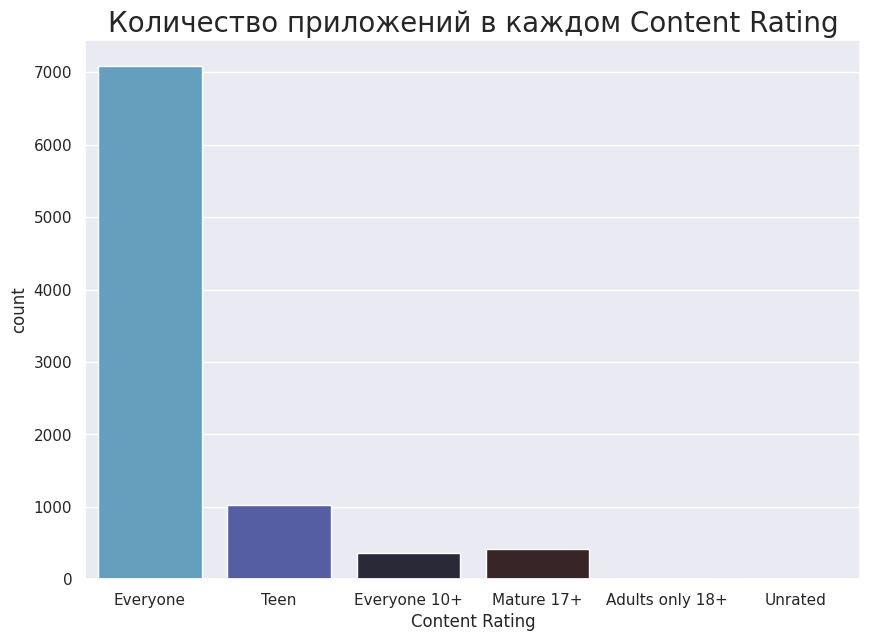

In [54]:
sns.set(rc={'figure.figsize': (10, 7)})

sns.countplot(x="Content Rating",
              data=data_typed,
              palette = "icefire");
plt.title('Количество приложений в каждом Content Rating',size = 20);

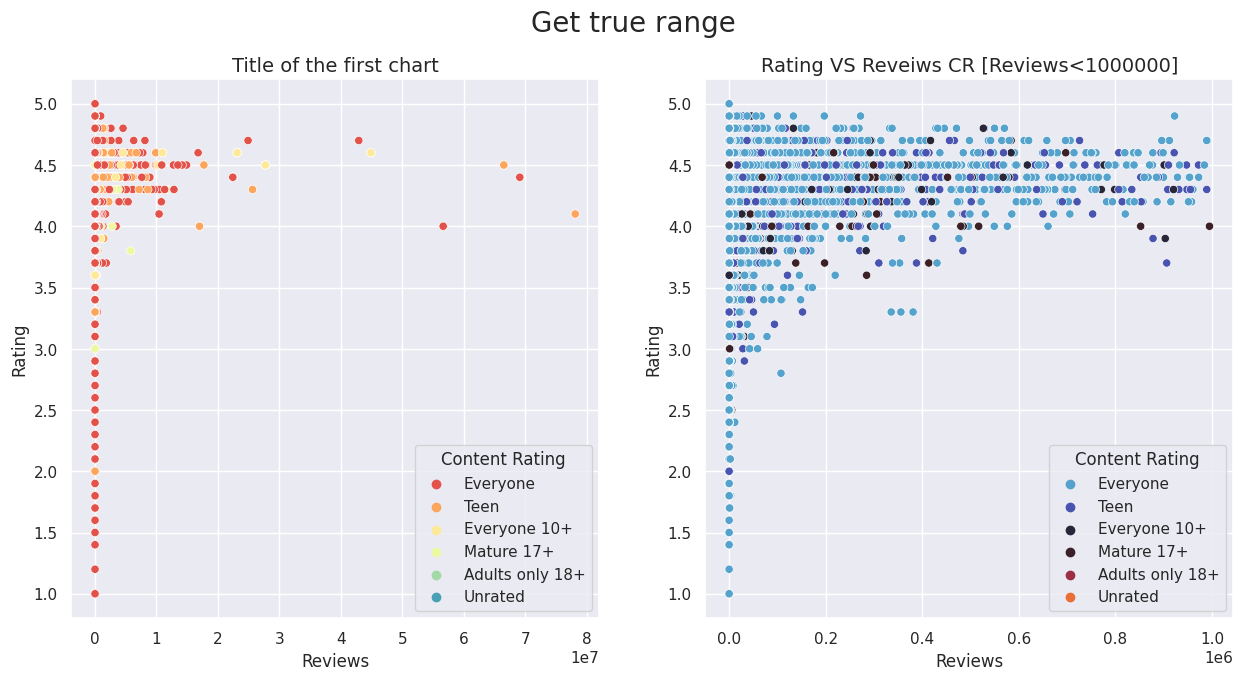

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Get true range', size=20)

sns.scatterplot(x='Reviews',
                y='Rating',
                hue='Content Rating',
                data=data_typed,
                palette='Spectral',
                ax=axes[0])
axes[0].set_title('Title of the first chart', size=14)


sns.scatterplot(x='Reviews',
                y='Rating',
                hue='Content Rating',
                data=data_typed[data_typed['Reviews']<1000000],
                palette="icefire",
                ax=axes[1])
axes[1].set_title('Rating VS Reveiws CR [Reviews<1000000]', size=14);

,Rating
Last Updated,
2010,4.200000
2011,3.966667
2012,3.785714
2013,4.069231
2014,4.036757
2015,4.064491
2016,4.039342
2017,4.093960
2018,4.242034


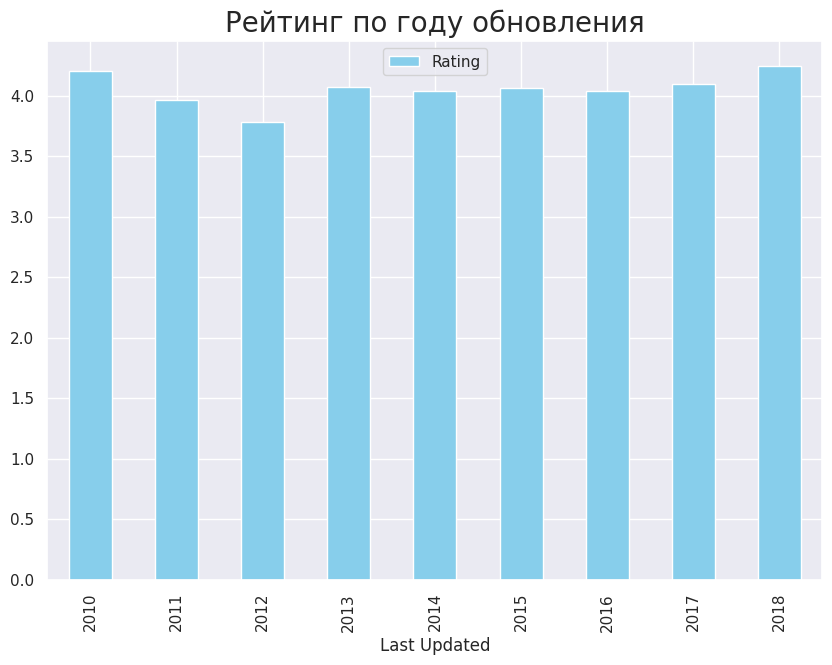

In [56]:
sns.set(rc={'figure.figsize': (10, 7)})

temp_group = data_typed.groupby('Last Updated')[['Rating']].mean()
display(HTML(temp_group.to_html()))

temp_group.plot(kind='bar', color="skyblue")
plt.title('Рейтинг по году обновления',size = 20);

,Rating
Category,
ART_AND_DESIGN,4.377049
AUTO_AND_VEHICLES,4.190411
BEAUTY,4.278571
BOOKS_AND_REFERENCE,4.347458
BUSINESS,4.102593
COMICS,4.155172
COMMUNICATION,4.151466
DATING,3.971698
EDUCATION,4.375969


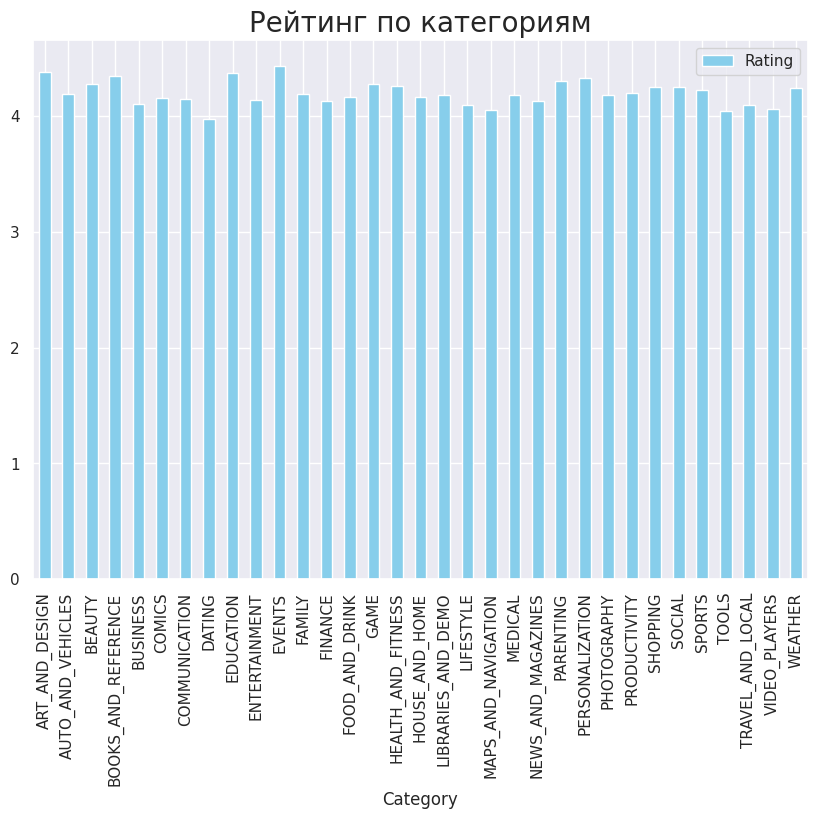

In [57]:
sns.set(rc={'figure.figsize': (10, 7)})

temp_group = data_typed.groupby('Category')[['Rating']].mean()
display(HTML(temp_group.to_html()))

temp_group.plot(color="skyblue", kind='bar')
plt.title('Рейтинг по категориям',size = 20);

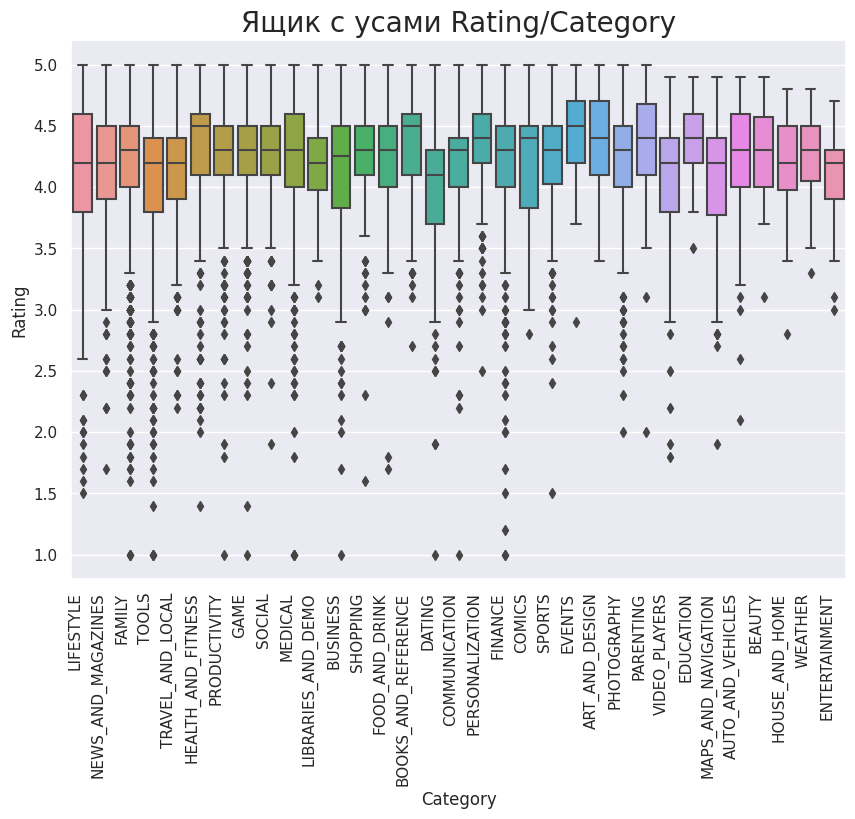

In [58]:
sns.set(rc={'figure.figsize': (10, 7)})

boxplot = sns.boxplot(y='Rating',
            x='Category',
            data=data_typed.sort_values('Rating',ascending=False))
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90, ha="right")

plt.title('Ящик с усами Rating/Category',size = 20);

,Rating
Type,
Free,4.182514
Paid,4.261702


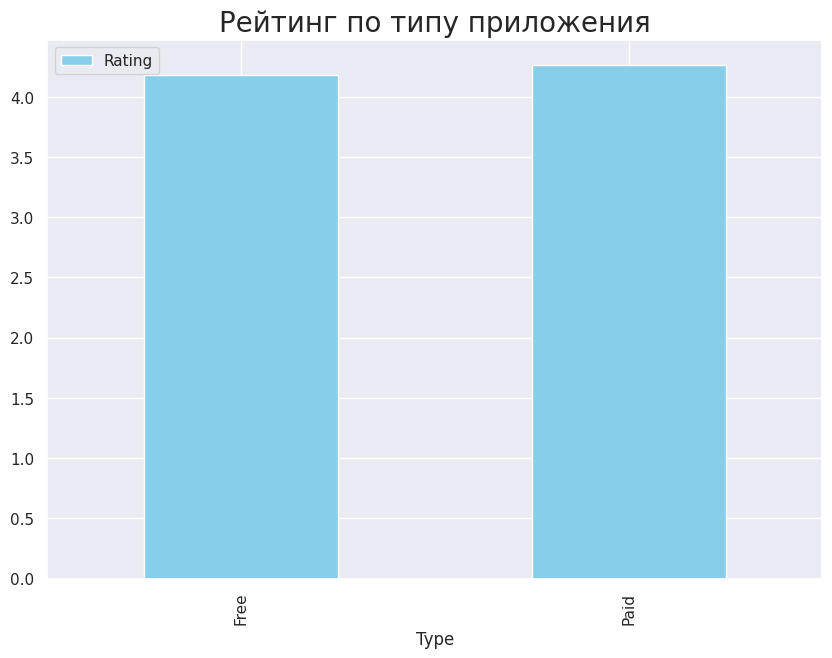

In [59]:
sns.set(rc={'figure.figsize': (10, 7)})

temp_group = data_typed.groupby('Type')[['Rating']].mean()
display(HTML(temp_group.to_html()))

temp_group.plot(color="skyblue", kind='bar')
plt.title('Рейтинг по типу приложения',size = 20);

# Последние шаги

In [60]:
print(data_typed.shape)
data_typed.head(5)

(8886, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,2018,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,2018,1.1,4.4 and up


Удаляем данные фичи, потому что они не несут никакой полезной информации о рейтинге + сложнообрабатываемые.


In [61]:
data = data_typed.drop(columns=['App', 'Genres', 'Current Ver', 'Android Ver'], axis=1)
data.head(5)

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated
0,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,2018
1,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,2018
2,ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,2018
3,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,2018
4,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,2018


In [62]:
LABEL = 'Rating'

X = data.drop(columns=[LABEL], axis=1)
y = np.array(data[LABEL])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

test = X_test.copy()
test['Rating'] = y_test

val = X_val.copy()
val['Rating'] = y_val

train = X_train.copy()
train['Rating'] = y_train

# Преобразование данных

In [63]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer_ss = StandardScaler()
numeric_transformer_mm = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

ct = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_ss, numerical_features),
        ('categ', categorical_transformer, categorical_features)
    ]
)

ct.set_output(transform='pandas')

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['Reviews', 'Size', 'Installs', 'Price', 'Last Updated'], dtype='object')),
                                ('categ',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['Category', 'Type', 'Content Rating'], dtype='object'))])

In [64]:
data_transform = ct.fit_transform(X_train)
data_transform['Rating'] = y_train
data_correlation = data_transform.corr()

data_correlation.style.background_gradient(cmap='coolwarm')

,num__Reviews,num__Size,num__Installs,num__Price,num__Last Updated,categ__Category_AUTO_AND_VEHICLES,categ__Category_BEAUTY,categ__Category_BOOKS_AND_REFERENCE,categ__Category_BUSINESS,categ__Category_COMICS,categ__Category_COMMUNICATION,categ__Category_DATING,categ__Category_EDUCATION,categ__Category_ENTERTAINMENT,categ__Category_EVENTS,categ__Category_FAMILY,categ__Category_FINANCE,categ__Category_FOOD_AND_DRINK,categ__Category_GAME,categ__Category_HEALTH_AND_FITNESS,categ__Category_HOUSE_AND_HOME,categ__Category_LIBRARIES_AND_DEMO,categ__Category_LIFESTYLE,categ__Category_MAPS_AND_NAVIGATION,categ__Category_MEDICAL,categ__Category_NEWS_AND_MAGAZINES,categ__Category_PARENTING,categ__Category_PERSONALIZATION,categ__Category_PHOTOGRAPHY,categ__Category_PRODUCTIVITY,categ__Category_SHOPPING,categ__Category_SOCIAL,categ__Category_SPORTS,categ__Category_TOOLS,categ__Category_TRAVEL_AND_LOCAL,categ__Category_VIDEO_PLAYERS,categ__Category_WEATHER,categ__Type_Paid,categ__Content Rating_Everyone,categ__Content Rating_Everyone 10+,categ__Content Rating_Mature 17+,categ__Content Rating_Teen,categ__Content Rating_Unrated,Rating
num__Reviews,1.000000,0.094122,0.611562,-0.009106,0.076626,-0.013791,-0.010560,-0.015598,-0.025083,-0.010924,0.111178,-0.019884,-0.013615,0.006002,-0.012245,-0.042740,-0.027930,-0.015691,0.093584,-0.020525,-0.012392,-0.014082,-0.027049,-0.006933,-0.028677,-0.017698,-0.011510,-0.015134,0.010182,-0.009171,-0.001183,0.088469,-0.012325,-0.003140,-0.016572,0.018896,-0.009158,-0.041570,-0.082217,0.079191,-0.008643,0.058798,-0.002107,0.065709
num__Size,0.094122,1.000000,0.018768,-0.013314,0.161208,-0.005731,-0.023651,-0.059231,-0.068015,-0.032887,-0.090704,-0.028260,-0.004125,-0.008286,-0.028649,0.169470,-0.028727,0.016718,0.390047,0.000958,-0.020345,-0.013908,-0.051278,-0.041759,-0.013906,-0.075896,-0.003899,-0.080017,-0.062826,-0.087611,-0.030475,-0.049550,0.034421,-0.180714,0.018315,-0.046570,-0.036815,-0.005850,-0.203188,0.161624,0.028981,0.134521,-0.009344,0.063726
num__Installs,0.611562,0.018768,1.000000,-0.011102,0.090933,-0.016335,-0.012430,-0.001884,-0.027685,-0.014134,0.158201,-0.023406,-0.018237,0.020780,-0.014441,-0.063696,-0.032571,-0.019077,0.038619,-0.020231,-0.014362,-0.016527,-0.031832,-0.014073,-0.034422,-0.000746,-0.013508,-0.022462,0.034678,0.066992,-0.007557,0.063797,-0.022431,0.002058,0.008753,0.037361,-0.012323,-0.051549,-0.048997,0.024379,-0.015367,0.056299,-0.002526,0.050400
num__Price,-0.009106,-0.013314,-0.011102,1.000000,-0.000371,-0.004875,-0.003951,-0.007619,-0.006471,-0.004588,-0.008950,-0.006338,-0.006044,-0.005543,-0.004522,-0.000903,0.067987,-0.006740,-0.015317,-0.008469,-0.004907,-0.005322,0.090403,-0.006825,0.017373,-0.008749,-0.003417,-0.004625,-0.007210,-0.009681,-0.008328,-0.010007,-0.006767,-0.012106,-0.007592,-0.007197,-0.002205,0.214536,0.018249,-0.004645,-0.006819,-0.015554,-0.000773,-0.026002
num__Last Updated,0.076626,0.161208,0.090933,-0.000371,1.000000,0.036248,0.019775,-0.029520,-0.002306,0.027829,0.017431,0.056875,-0.008092,0.037734,0.016830,-0.068046,0.065366,0.050522,-0.029094,0.044452,-0.000312,-0.020814,-0.009980,0.017099,-0.021024,0.037196,0.027922,-0.080389,0.002157,-0.015490,0.060917,0.028373,0.031655,-0.051574,0.032833,-0.027003,-0.008668,-0.174471,-0.049283,0.011695,0.043276,0.028954,-0.064027,0.128939
categ__Category_AUTO_AND_VEHICLES,-0.013791,-0.005731,-0.016335,-0.004875,0.036248,1.000000,-0.005985,-0.012288,-0.015597,-0.006950,-0.016642,-0.011816,-0.010682,-0.009272,-0.006849,-0.042933,-0.017122,-0.010210,-0.032493,-0.015075,-0.007433,-0.008062,-0.016730,-0.011072,-0.016059,-0.013614,-0.006432,-0.016464,-0.017036,-0.017379,-0.013294,-0.015267,-0.016420,-0.026937,-0.014133,-0.012054,-0.008062,-0.016066,0.039598,-0.008973,-0.018899,-0.031892,-0.001171,-0.007336
categ__Category_BEAUTY,-0.010560,-0.023651,-0.012430,-0.003951,0.019775,-0.005985,1.000000,-0.009431,-0.011970,-0.005334,-0.012772,-0.009068,-0.008199,-0.007116,-0.005257,-0.032950,-0.013141,-0.007836,-

# Построение модели регрессии и выбор гиперпараметров


In [65]:
model = LinearRegression()
clf = Pipeline(steps=[('transformation', ct),
                      ('regressor', model)])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Val rmse - {rmse}")

Val rmse - 0.5099824141413828


## Linear Regression + L1

In [66]:
%%time
def objective(trial):
    model = Lasso(
        max_iter=trial.suggest_int("max_iter", 500, 1500),
        tol=trial.suggest_float("tol", 1e-5, 1e-3),
        alpha=trial.suggest_float("alpha", 0.0, 5.0),
        random_state=42
    )
    clf = Pipeline(steps=[('transformation', ct),
                          ('regressor', model)])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return mean_squared_error(y_val, y_pred, squared=False)

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="lasso", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=200)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

Number of finished trials:  200
Best trial:
  Value:  0.5093739233222405
  Params: 
    max_iter: 562
    tol: 0.000630712529116489
    alpha: 0.0016513892604275368

CPU times: user 46 s, sys: 42.8 s, total: 1min 28s
Wall time: 23.5 s
